In [240]:
import sys
sys.path.append('../')
sys.path.append('../support/')
sys.path.append('../lung_segmentation/')
import os
import SimpleITK
from preprocessing import *
from lung_separation import *
from ct_reader import *
from os.path import join, basename, isfile
from glob import glob
from scipy.ndimage import morphology
from skimage import filters
from skimage import exposure
from tqdm import tqdm
from skimage import morphology as skm
from skimage.morphology import watershed

from scipy.ndimage import generate_binary_structure
from skimage import measure
from multiprocessing import Pool
import pickle
from segmentation import *

%pylab inline
# import warnings
# warnings.filterwarnings('ignore')

import SimpleITK as sitk
from paths import * 
from skimage.transform import resize
from scipy.ndimage import label

Populating the interactive namespace from numpy and matplotlib


In [3]:
def read_ct(path, ret_xy_spacing=False):
    patient = read_ct_scan(path)
    image = get_pixels_hu(patient)
    image[image == image[0,0,0]] = 0
    
    if ret_xy_spacing:
        try:
            return image, patient[0].PixelSpacing[0]
        except AttributeError:
            return image, scan.GetSpacing()[0]
    
    return image

In [4]:
NUM_SEED_SLICES = 25
BRONCHIAL_THRESHOLD = -900
INITIAL_THRESHOLD = -950
STEP = 64
CPU = 24

properties:  

    average HU below −950,  
    minimum size of 50 mm^2 ,   
    maximum size of 1225 mm^2 ,   
    mean x- and y-coordinates not further than 30%   
    of the x- and y-dimensions of the image away from the center of the slice.  

In [5]:
def region_growing(img, seed, minthr, maxthr, structure=None):
    """code was taken from:
    https://github.com/loli/medpy/wiki/Basic-image-manipulation
    """
    img[seed] = minthr
    thrimg = (img < maxthr) & (img >= minthr)
    lmap, _ = label(thrimg, structure=structure)
    lids = unique(lmap[seed])
    region = zeros(img.shape, numpy.bool)
    for lid in lids:
        region |= lmap == lid
    return region

In [6]:
def extract_bronchial(ct_slice, xy_spacing):
    labeled = measure.label(ct_slice < BRONCHIAL_THRESHOLD)
    areas = bincount(labeled.flatten())
    labels = [i 
              for i, area in enumerate(areas) 
              if (area * xy_spacing >= 50) and (area * xy_spacing <= 1225)]
    coords = [where(labeled == i) for i in labels]

    center = array(ct_slice.shape) // 2
    max_dist = array(ct_slice.shape) * .3
    labels = [(mean(coord, axis=1), labe)
              for labe, coord in zip(labels, coords) 
              if (abs(center - mean(coord, axis=1)) < max_dist).all()]
    
    if len(labels) != 0:
        return labeled == min(labels, key=lambda x: sum((x[0] - center) ** 2))[1]
    
    return None

In [7]:
def select_bronchial(bronchials, ct_slices, levels):
    center = array(bronchials[0].shape) // 2
    coords = [(mean(where(bool_slice), axis=1), i) 
              for i, bool_slice in enumerate(bronchials)]
    el = min(coords, key=lambda x: sum((x[0] - center) ** 2))
    return bronchials[el[1]], ct_slices[el[1]], levels[el[1]]


def select_seeds(bronchial, ct_clice):
    return ct_clice * bronchial == ct_clice[bronchial].min()

In [8]:
def extract_seeds(patient, xy_spacing):
    bronchials = list()
    bronch_cts = list()
    levels = list()
    for i in range(55):
        bronchial = extract_bronchial(patient[i], xy_spacing)
        if bronchial is not None:
            bronchials.append(bronchial)
            bronch_cts.append(patient[i])
            levels.append(i)

            
    for i in range(-55, 0, 1):
        bronchial = extract_bronchial(patient[i], xy_spacing)
        if bronchial is not None:
            bronchials.append(bronchial)
            bronch_cts.append(patient[i])
            levels.append(i)
            
    bronchial, ct_slice, level = select_bronchial(bronchials, 
                                                  bronch_cts, 
                                                  levels)
    
    seeds = zeros(patient.shape)
    seeds[level] = select_seeds(bronchial, ct_slice)

    return seeds

In [9]:
def growing_bronchis(patient, seeds, 
                     threshold=INITIAL_THRESHOLD, 
                     step=STEP,
                     full_extraction=True):
    
    
    seeds = seeds.astype(bool_)
    seeds = region_growing(patient.copy(), seeds, -5010, threshold)
    volume = count_nonzero(seeds)
    
    lungs_thresh = filters.threshold_otsu(patient[patient.shape[0] // 2])
    
    ret = None
    while True:    
        labeled = region_growing(patient.copy(), seeds, -5010, threshold + step)
        new_volume = count_nonzero(labeled)
        if new_volume >= volume * 2:
            if step == 4:
                ret = seeds.copy()
                if not full_extraction:
                    return ret
                
            if step == 2:
                return ret, seeds
            step = ceil(step * 0.5)
            continue
        
        threshold += step
        volume = new_volume
        seeds = labeled
        
        if threshold >= lungs_thresh:
            if ret is None:
                ret = seeds.copy()
            
            if not full_extraction:
                return ret
            
            return ret, seeds

In [10]:
def grow_lungs(patient, seeds):
    lungs_seeds = patient * seeds == patient[seeds].min()
    lungs_seeds = lungs_seeds.astype(bool_)
    threshold = filters.threshold_otsu(patient[patient.shape[0] // 2])

    lungs_seeds = region_growing(patient.copy(), lungs_seeds, -1010, threshold)
    return morphology.binary_opening(lungs_seeds - morphology.binary_opening(seeds))


def lung_separation(patient, lungs_seeds):
    labeled = label(lungs_seeds)[0]
    markers = bincount(labeled.flatten())
    markers = vstack([markers[1:], arange(1, markers.shape[0])])
    markers = asarray(sorted(markers.T, key=lambda x: x[0]))[-2:]
    if len(markers) < 2:
        left, right = separate_lungs3d(lungs_seeds)
        return left, right, True
    
    if markers[0, 0] / markers[1, 0] < 0.3:
        left, right = separate_lungs3d(lungs_seeds)
        return left, right, True
    
    centroids = (mean(where(labeled == markers[0, 1]), axis=1)[-1],
                 mean(where(labeled == markers[1, 1]), axis=1)[-1])
    
    if centroids[0] > centroids[1]:
        return labeled == markers[1, 1], labeled == markers[0, 1], False
    
    return labeled == markers[0, 1], labeled == markers[1, 1], False


def lungs_postprocessing(lungs_seeds):
    for i in range(lungs_seeds.shape[1]):
        lungs_seeds[:, i] = morphology.binary_fill_holes(lungs_seeds[:, i])
    return lungs_seeds

In [241]:
def plot_lungs_structures(left, right, trachea, bronchi, patient=None, plot=True):
    """
    Structure:
        1.  left lung
        2.  right lung
        4.  bronchi
        8.  trachea
        
        3.  left    overlapped by right
        
        5.  bronchi overlapped by left
        6.  bronchi overlapped by right
        7.  bronchi overlapped by right, overlapped by left
        
        9.  trachea overlapped by left
        10. trachea overlapped by right
        11. trachea overlapped by right, overlapped by left
            
        12. bronchi overlapped by trachea
        13. bronchi overlapped by trachea, overlapped by left
        14. bronchi overlapped by trachea, overlapped by right
        15. bronchi overlapped by trachea, overlapped by right, overlapped by left
    """
    if plot:
        figure(figsize=(10,10))
        subplot(131)
        combined = left + trachea * 2 + bronchi * 4 + right * 8 
        imshow(combined[right.shape[0] // 2]);
        subplot(132)
        imshow(resize(combined[:, right.shape[1] // 2].astype(float64), 
                      [right.shape[1], right.shape[1]]));
        if patient is not None:
            subplot(133)
            imshow(patient[right.shape[0] // 2])
            show()
    return left + right * 2 + bronchi * 4 + trachea * 8

In [489]:
def conventional_lung_segmentation(patient, xy_spacing, plot=True):
    seeds = extract_seeds(patient, xy_spacing)
    trachea, bronchi = growing_bronchis(patient, seeds)
    
#     print('-'*30)
#     print('Bronchisare grown')
    lungs_seeds = grow_lungs(patient, trachea)

    left, right, state = lung_separation(patient, lungs_seeds)
    selem = skm.ball(int(patient.shape[-1] * .01))
    
#     print('-'*30)
#     print('Lungs are grown & separated')
    left = skm.binary_closing(left, selem)
    right = skm.binary_closing(right, selem)

    right = morphology.binary_fill_holes(right)
    left = morphology.binary_fill_holes(left)

    left = lungs_postprocessing(left)
    right = lungs_postprocessing(right)
    
#     print('-'*30)
#     print('Smoothing has been applied')
    return plot_lungs_structures(left, 
                                 right, 
                                 trachea, 
                                 bronchi, 
                                 patient,
                                 plot).astype(int8), state

In [13]:
patients_files = glob(join(PATH['LUNA_DATA'], 'subset*', '*.mhd'))

for path in tqdm(patients_files):
    patient, xy_spacing = read_ct(path, True)
    combined = conventional_lung_segmentation(patient, xy_spacing)
    save(join(PATH['LUNA_MASKS'], basename(path).split('.mhd')[0]), combined)

In [615]:
patients = glob(join(PATH['STAGE_MASKS'], '*.npy'))
num = 300
patient = load(patients[num])
z_pos = -95

separated = separate_lungs3d(patient > 0)

patient = read_ct_scan(join(PATH['STAGE_DATA'], basename(patients[num])[:-4]))
image = get_pixels_hu(patient)
patient, _ = resample(image, patient, [1., 1., 1.])
# patient = image
seeds = extract_seeds(patient, 1.)
trachea, bronchi = growing_bronchis(patient, seeds)
segmented = grow_lungs(patient, trachea)

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


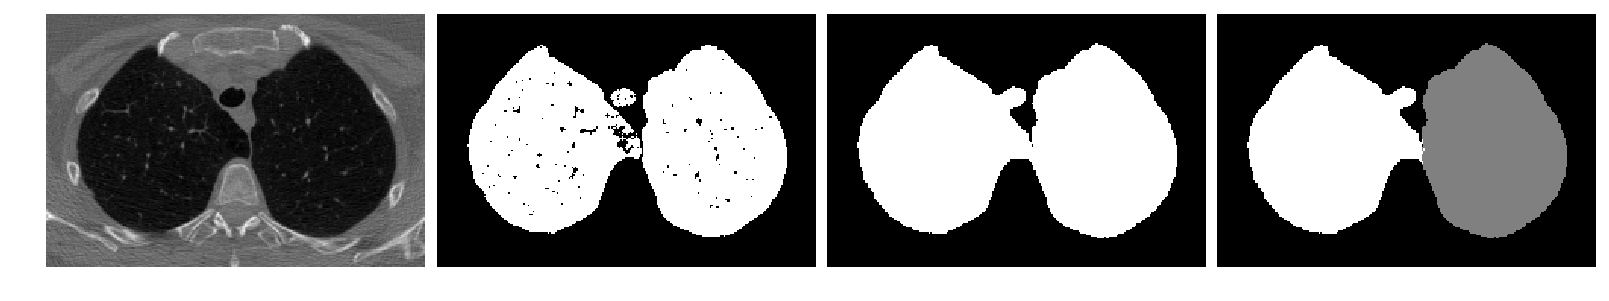

In [614]:
import seaborn as sns
sns.reset_defaults()
gray()
border = 20
mask = separated[1][patient.shape[0] // 2 + z_pos] + separated[0][patient.shape[0] // 2 + z_pos]
separ = mask + separated[0][patient.shape[0] // 2 + z_pos]

y, x = where(mask)
y_max, y_min = max(y) + border, min(y) - border
x_max, x_min = max(x) + border, min(x) - border

figure(figsize=(20, 10));
ax = subplot(1, 4, 1);
ax.autoscale_view('tight');
imshow(patient[patient.shape[0] // 2 + z_pos, y_min: y_max, x_min: x_max]);
# imshow(patient[patient.shape[0] // 2 + z_pos - 1: patient.shape[0] // 2 + z_pos + 2, y_min: y_max, x_min: x_max].max(0))
axis('off');

ax = subplot(1, 4, 2);
ax.autoscale_view('tight');
imshow(segmented[0][segmented[0].shape[0] // 2 + z_pos, y_min: y_max, x_min: x_max]);
axis('off');

ax = subplot(1, 4, 3);
ax.autoscale_view('tight');
imshow(mask[y_min: y_max, x_min: x_max]);
axis('off');

ax = subplot(1, 4, 4);
ax.autoscale_view('tight');
imshow(separ[y_min: y_max, x_min: x_max]);
axis('off');
subplots_adjust(wspace=.03, hspace=-.10);
show();

In [12]:
def operate(path, out_dir='DATA_OUT'):
    patient, xy_spacing = read_ct(path, True)
    combined, state = conventional_lung_segmentation(patient, xy_spacing, False)
    if 'luna' in out_dir.lower():
        save(join(PATH[out_dir], basename(path).split('.mhd')[0]), combined)
    else:
        save(join(PATH[out_dir], basename(path)), combined)
    if isfile(join(PATH[out_dir], 'manual.npy')):
        manuals = load(join(PATH[out_dir], 'manual.npy')).tolist()
    else:
        manuals = list()
        
    if state:
        manuals.append(path)
    save(join(PATH[out_dir], 'manual'), asarray(manuals))
    if state:
        return path
    return None

In [82]:
file_list = set(basename(path).split('.mhd')[0] for path in glob(join(PATH['LUNA_DATA'], 'subset*', '*.mhd')))
file_list = file_list.difference([basename(path).split('.npy')[0] 
                                        for path in glob(join(PATH['LUNA_MASKS'], '*.npy'))])
file_list = [[join(PATH['LUNA_DATA'], 'subset' + str(i), base_name + '.mhd') 
              for i in range(10) 
              if isfile(join(PATH['LUNA_DATA'], 'subset' + str(i), base_name + '.mhd'))] 
             for base_name in file_list]
file_list = [path[0] for path in file_list]

manuals = list()
with Pool(CPU) as pool:
    manuals = pool.map(operate,  file_list)

manuals += load(join(PATH['LUNA_MASKS'], 'manual.npy')).tolist()
save(join(PATH['LUNA_MASKS'], 'manual_pool'), asarray(manuals))

In [ ]:
file_list = set(basename(path) for path in glob(join(PATH['DATA'], '*')))
file_list = file_list.difference([basename(path).split('.npy')[0] 
                                  for path in glob(join(PATH['DATA_OUT'], '*.npy'))])
file_list = [join(PATH['DATA'], base_name) 
             for base_name in file_list]

manuals = list()
with Pool(CPU) as pool:
    manuals = pool.map(operate,  file_list)

manuals += load(join(PATH['LUNA_MASKS'], 'manual.npy')).tolist()
save(join(PATH['LUNA_MASKS'], 'manual_pool'), asarray(manuals))

In [ ]:
lung = (left.copy() == 1).astype(float)

coords = where(lung)
# for i in tqdm(unique(coords[0])):
value = 0
volume = count_nonzero(lung)
for coord in tqdm(unique(coords[2])):
    value += count_nonzero(lung[:, :, coord])
    lung[:, :, coord][lung[:, :, coord] != 0] = value / float(volume)


In [16]:
diff = zeros(lung.shape)
for i in tqdm(unique(coords[0])):
    diff[i] = skm.convex_hull_object((lung[i] < .8) * (lung[i] != 0)) - (lung[i] < .8) * (lung[i] != 0)

  0%|          | 0/332 [00:00<?, ?it/s]/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  app.launch_new_instance()
100%|██████████| 332/332 [00:48<00:00,  6.85it/s]


In [ ]:
for i in unique(coords[0]):
    if i % 3 == 0:
        subplot(131)
        imshow(diff[i])
        subplot(132)
        imshow(patient[i])
        subplot(133)
        imshow(left[i])
        show()

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  app.launch_new_instance()


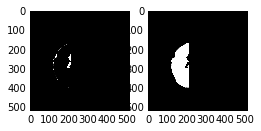

In [137]:
gray()
subplot(131)
imshow(skm.convex_hull_object((lung[154] < .8) * (lung[154] != 0)) - (lung[154] < .8) * (lung[154] != 0))
subplot(132)
imshow((lung[154] < .8) * (lung[154] != 0))
subplot(132)

In [ ]:
coords[axis]

In [126]:
seeds = extract_seeds(patient, xy_spacing)
trachea, bronchi = growing_bronchis(patient, seeds)
lungs_seeds = grow_lungs(patient, trachea)

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


In [ ]:
vale = list()

ct_scan = read_ct_scan(join(PATH['DATA'],erroneus[113]))

ct_scan_px = get_pixels_hu(ct_scan)
ct_mask_F = segment_lung_mask(ct_scan_px, False)
ct_mask_T = segment_lung_mask(ct_scan_px, True)
ct_mask_diff = ct_mask_T - ct_mask_F
# start = time.time()

segmented = list()
lung_filter = list()
sobel = list()

ct_excluded = []
for ct_slice in ct_scan_px:
    ct_excluded.append(exclude_lungs(ct_slice))

# end = time.time()
# print(end - start)

for ct_slice in ct_excluded:
    segmented.append(ct_slice[0])
    lung_filter.append(ct_slice[1].astype(bool_))
    sobel.append(ct_slice[2] * ct_slice[1])

lung_filter = asarray(lung_filter)
left, right = separate_lungs3d(lung_filter)

In [ ]:
import sys
sys.path.append('../')
sys.path.append('../support/')
sys.path.append('../lung_segmentation/')
import os
import SimpleITK
from lung_separation import *
from ct_reader import *
from os.path import join, basename, isfile
from glob import glob
from scipy.ndimage import morphology
from skimage import filters
from skimage import exposure
from tqdm import tqdm
from skimage import morphology as skm
from skimage.morphology import watershed
from scipy.ndimage import label
from scipy.ndimage import generate_binary_structure
from skimage import measure
from multiprocessing import Pool
import pickle
from segmentation import *

%pylab inline
# import warnings
# warnings.filterwarnings('ignore')

import SimpleITK as sitk
from paths import * 
from skimage.transform import resize


erroneus = sorted(list(set(pickle.load(open(join(PATH['WEIGHTS'], 'erroneus'), 'rb')))))
erroneus = [join(PATH['DATA'],err) for err in erroneus]

def operate(path, out_dir='DATA_OUT'):
    vale = list()

    ct_scan = read_ct_scan(path)

    ct_scan_px = get_pixels_hu(ct_scan)
    ct_mask_F = segment_lung_mask(ct_scan_px, False)
    ct_mask_T = segment_lung_mask(ct_scan_px, True)
    ct_mask_diff = ct_mask_T - ct_mask_F
    # start = time.time()

    segmented = list()
    lung_filter = list()
    sobel = list()

    with Pool(42) as pool:
        ct_excluded = pool.map(exclude_lungs, ct_scan_px)

    # end = time.time()
    # print(end - start)

    for ct_slice in ct_excluded:
        segmented.append(ct_slice[0])
        lung_filter.append(ct_slice[1].astype(bool_))
        sobel.append(ct_slice[2] * ct_slice[1])

    lung_filter = asarray(lung_filter)
    left, right = separate_lungs3d(lung_filter)
    save(join(join('/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/TRAIN_OUT/FIXED','FIXED'),basename(path)),left+2*right)

for err in erroneus:
    operate(err)

Populating the interactive namespace from numpy and matplotlib


/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


In [29]:
path = erroneus[0]
ct_scan = read_ct_scan(path)

ct_scan_px = get_pixels_hu(ct_scan)
ct_mask_F = segment_lung_mask(ct_scan_px, False)
ct_mask_T = segment_lung_mask(ct_scan_px, True)
ct_mask_diff = ct_mask_T - ct_mask_F
image = ct_scan_px[70]
marker_internal, marker_external, marker_watershed = generate_markers(image)
img_shape = image.shape

# Creation of the Sobel-Gradient
sobel_filtered_dx = ndimage.sobel(image, 1)
sobel_filtered_dy = ndimage.sobel(image, 0)
sobel_gradient = hypot(sobel_filtered_dx, sobel_filtered_dy)
sobel_gradient *= 255.0 / sobel_gradient.max()

# Watershed algorithm
watershed = morphology.watershed(sobel_gradient, marker_watershed)

# Reducing the image created by the Watershed algorithm to its outline
outline = ndimage.morphological_gradient(watershed, size=(3, 3))
outline = outline.astype(bool)

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
